### Libraries:

In [1]:
import os
import gdown
import tifffile as tiff
from imageio import imread
import numpy as np
import matplotlib.pyplot as plt

### Download Tiff Stacks:

In [2]:
FOLDER_ID = "1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54"

os.makedirs("data")

!gdown --folder https://drive.google.com/drive/folders/$FOLDER_ID -O data

FileExistsError: [Errno 17] File exists: 'data'

In [3]:
embryos = sorted([f for f in os.listdir("data")])
print(embryos)
# Shapes:
for t in range(len(embryos)):
  file_path = os.path.join("data", embryos[t])
  img = tiff.imread(file_path)
  print("File: ",embryos[t]," - Shape:", img.shape)

['Control1.tif', 'Control2.tif', 'Mutant1.tif', 'Mutant2.tif', 'Mutant3.tif', 'Mutant4.tif']
File:  Control1.tif  - Shape: (450, 200, 200)
File:  Control2.tif  - Shape: (450, 200, 200)
File:  Mutant1.tif  - Shape: (450, 200, 200)
File:  Mutant2.tif  - Shape: (450, 200, 200)
File:  Mutant3.tif  - Shape: (450, 200, 200)
File:  Mutant4.tif  - Shape: (450, 200, 200)


### Plot of the Embryos:

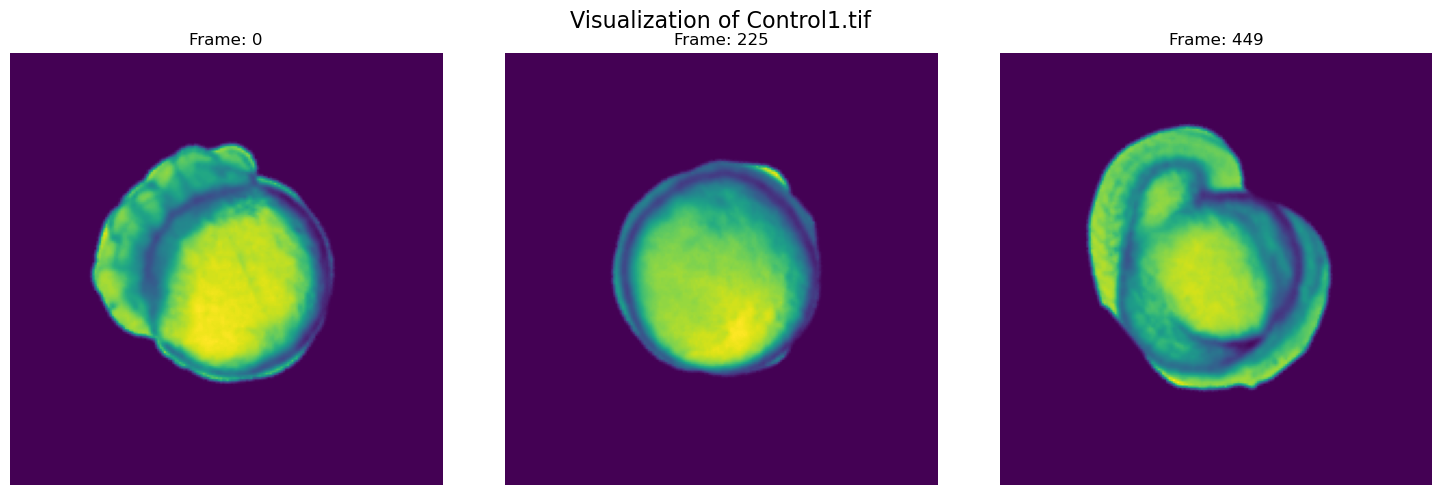

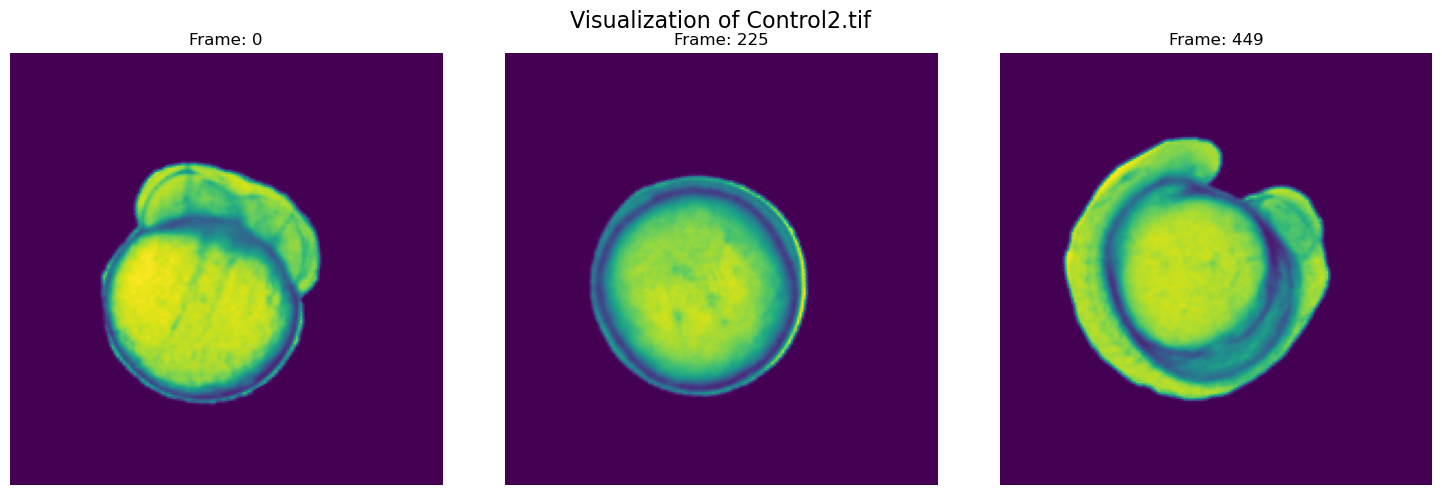

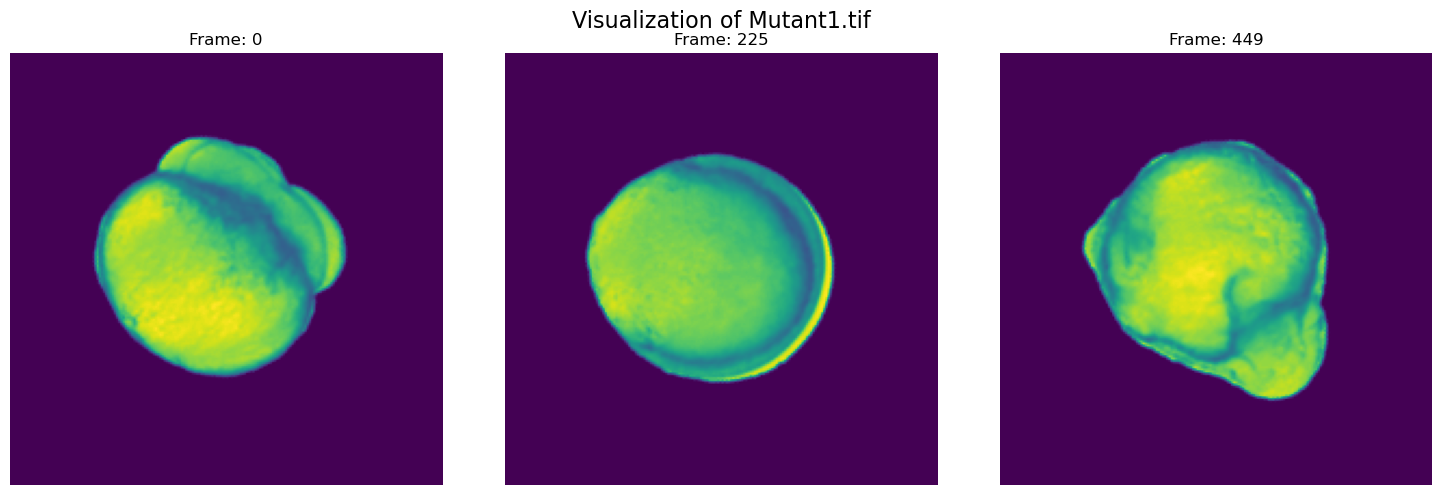

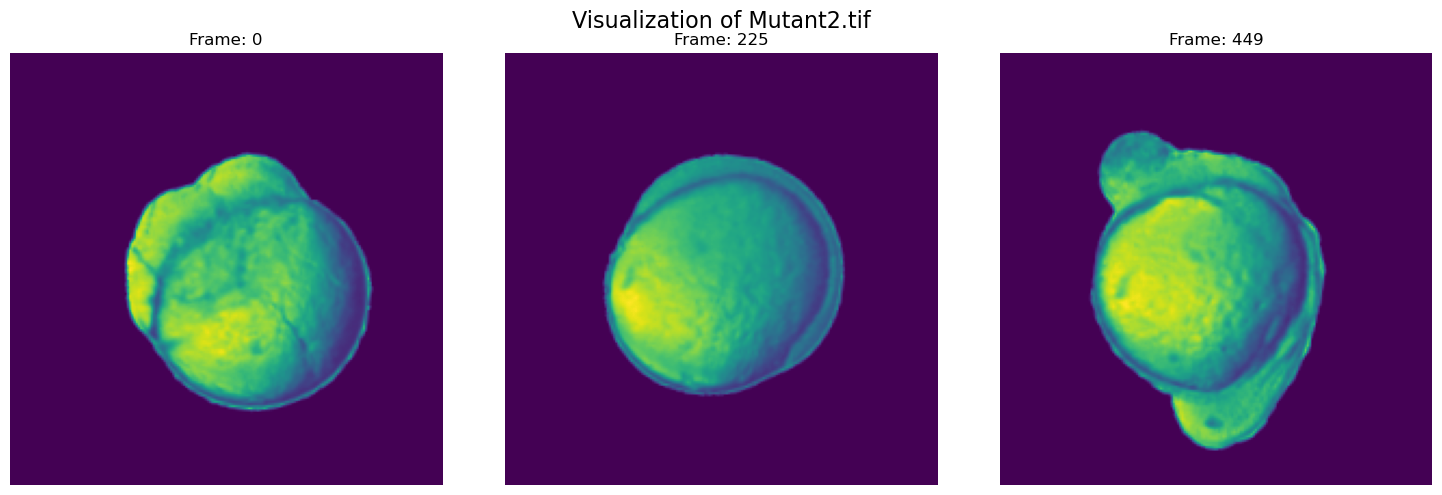

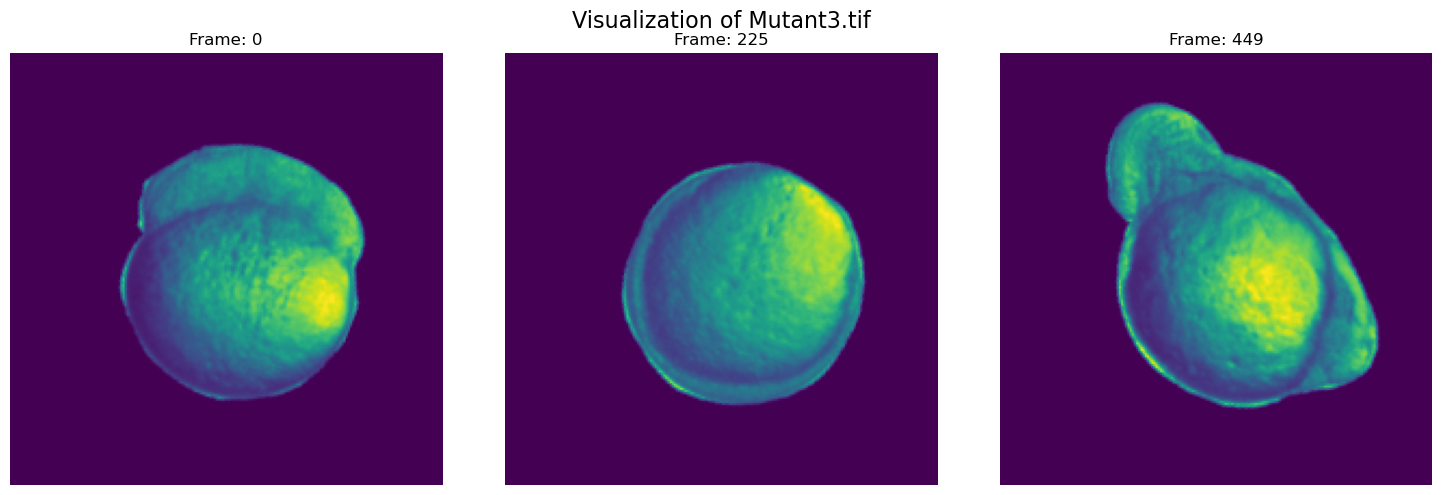

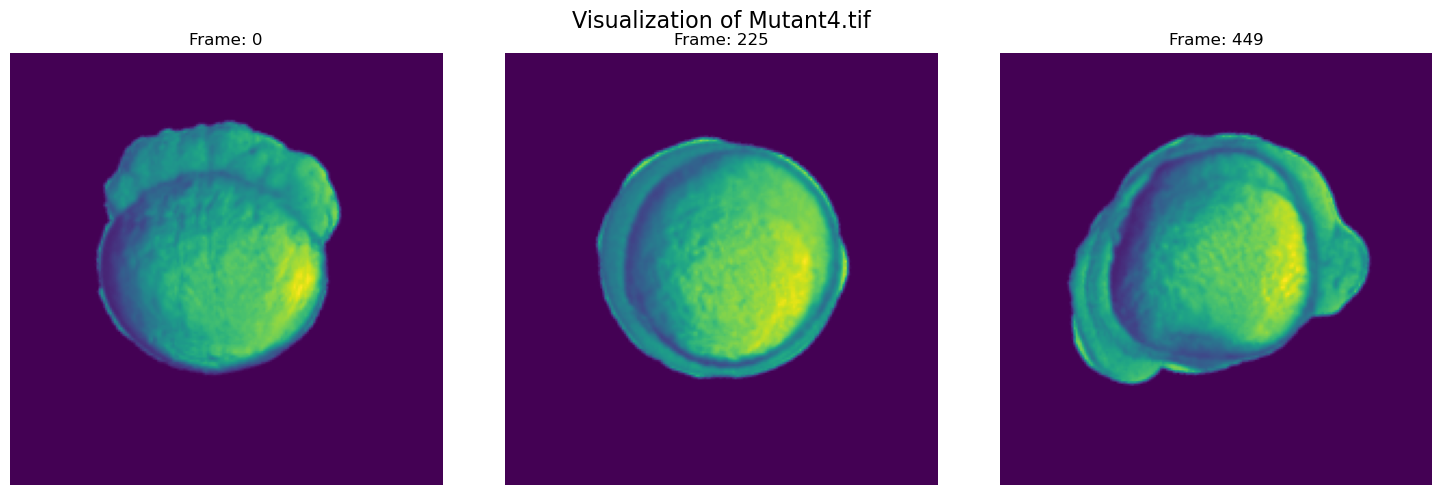

In [4]:
for t in range(len(embryos)):
    # Route
    file_path = os.path.join("data", embryos[t])
    # Tiff into Numpy array
    embryo_stack = tiff.imread(file_path)
    # Frames explored
    time_points = [0, len(embryo_stack) // 2, len(embryo_stack) - 1]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, tp_index in enumerate(time_points):
        ax = axes[i]
        ax.imshow(embryo_stack[tp_index])
    
        ax.set_title(f"Frame: {tp_index}")
        ax.axis("off")
        
    plt.suptitle(f"Visualization of {embryos[t]}", fontsize=16)
    plt.tight_layout()
    plt.show()

### Normalization

In [5]:
normalized_data = {}

for name in embryos:
    file_path = os.path.join("data", name)
    # Stack
    stack = tiff.imread(file_path)
    # Uint8: max pixel value 255
    normalized_stack = stack.astype("float32") / 255.0
    # Save in a dictionary
    # Key is the name without .tif 
    key_name = name.split('.')[0]
    normalized_data[key_name] = normalized_stack
    
print(f"Keys in normalized_data: {list(normalized_data.keys())}")

Keys in normalized_data: ['Control1', 'Control2', 'Mutant1', 'Mutant2', 'Mutant3', 'Mutant4']


### Sliding Window

In [6]:
def create_sequences(data_stack, n_past, n_future):
    """
    Take a stack (N, H, W) and turn in into a sequences (X, y) 

    Args: 
    data_stack (np.array): Normalized stack
    n_past (int): The number of frames used for the input (past)
    n_future (int): The number of frames to predict (future)
    
    Returns:
    (np.array, np.array): a tuple (X,y)
    X: (n_samples, n_past, H, W)
    y: (n_samples, n_future, H, W)
    """
    X_list, y_list = [],[]
    # Number of frames:
    total_frames = len(data_stack)

    # Loop for sliding the window
    for i in range(total_frames - n_past - n_future + 1):
        # Past initial index
        past_start = i
        # Past last index
        past_end = past_start + n_past

        # Past initial index
        future_start = past_end
        # Past last index
        future_end = future_start + n_future

        # Data store
        X_seq = data_stack[past_start : past_end]
        y_seq = data_stack[future_start : future_end]
        X_list.append(X_seq)
        y_list.append(y_seq)

    return np.array(X_list), np.array(y_list)

In [7]:
# Parameters for the model
N_PAST = 10
N_FUTURE = 1
TRAIN_SPLIT_PERCENT = 0.8
TARGET_EMBRYO = 'Control1'

target_stack = normalized_data[TARGET_EMBRYO]
X_all_seqs, y_all_seqs = create_sequences(target_stack, N_PAST, N_FUTURE)
total_samples = len(X_all_seqs)
print("Number of total sequences: ", total_samples)

#Divide the train and validation sets
split_index = int(total_samples * TRAIN_SPLIT_PERCENT)
print(f"Number of sequences for training:  {split_index} ({TRAIN_SPLIT_PERCENT*100} %)")
# Train set
X_train = X_all_seqs[:split_index]
y_train = y_all_seqs[:split_index]
# Validation set
X_val = X_all_seqs[split_index:]
y_val = y_all_seqs[split_index:]
print("Shape: ",X_all_seqs.shape)

Number of total sequences:  440
Number of sequences for training:  352 (80.0 %)
Shape:  (440, 10, 200, 200)


### Building ConvLSTM

Import Libraries and GPU setting

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Add Channel Dimension adn rearrange for pytorch

In [9]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1) 
y_val = np.expand_dims(y_val, axis=-1)
print("Shape: ",X_train.shape)

Shape:  (352, 10, 200, 200, 1)


In [10]:
X_train_np = np.moveaxis(X_train, -1, 2)
X_val_np = np.moveaxis(X_val, -1, 2)
y_train_np = np.moveaxis(y_train, -1, 1)
y_val_np = np.moveaxis(y_val, -1, 1)
print(f"PyTorch-ready X_train shape: {X_train_np.shape}")

PyTorch-ready X_train shape: (352, 10, 1, 200, 200)


Create PyTorch Tensors

In [18]:
X_train_tensor = torch.from_numpy(X_train_np).float()
y_train_tensor = torch.from_numpy(y_train_np).float()

X_val_tensor = torch.from_numpy(X_val_np).float()
y_val_tensor = torch.from_numpy(y_val_np).float()
#print(X_val_tensor.shape)
if y_train_tensor.dim() == 5:
    print("Fixing y_tensor shape (squeezing dim 2)...")
    y_train_tensor = y_train_tensor.squeeze(2)
    y_val_tensor = y_val_tensor.squeeze(2)
    print(f"y_train_tensor shape: {y_train_tensor.shape}")

Fixing y_tensor shape (squeezing dim 2)...
y_train_tensor shape: torch.Size([352, 1, 200, 200])


Create DataLoaders

In [12]:
BATCH_SIZE = 2

# Create TensorDatasets
# This pairs each X (input sequence) with its corresponding y (target frame)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
# shuffle=True: Randomizes the training data order each epoch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# shuffle=False: No need to shuffle validation data (Just for testing)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### ConvLSTM Library Code

In [13]:
class ConvLSTMCell(nn.Module): #Takes the previous latent space and the actual frame and build a newlatent space

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):  #Compute in sequence the ConvLSTMCell and build a new latent space after the N frames 

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        if hidden_state is None:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

print("ConvLSTMCell and ConvLSTM classes imported successfully.")

ConvLSTMCell and ConvLSTM classes imported successfully.


#### Forecaster Model

In [19]:
class Forecaster(nn.Module):  #Takes the new latent space from ConvLSTM and appy aCNN to build the prediction image
    def __init__(self, input_dim, hidden_dims, kernel_size, num_layers):
        super(Forecaster, self).__init__()
        
        # --- 1. The ConvLSTM engine ---
        # We use the class we just imported.
        # hidden_dims can be a list, e.g., [32, 64] for 2 layers
        self.convlstm = ConvLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=num_layers,
            batch_first=True,  # Very important!
            bias=True,
            return_all_layers=False # We only care about the output of the last layer
        )
        
        # --- 2. The final prediction layer ---
        # This layer takes the output from the last ConvLSTM layer
        # (which has 'hidden_dims[-1]' channels) and collapses it
        # back to our 'input_dim' (1 channel).
        self.final_conv = nn.Conv2d(
            in_channels=hidden_dims[-1], # Output channels from the last LSTM layer
            out_channels=input_dim,      # 1 output channel (our prediction)
            kernel_size=(3, 3),          # 3x3 kernel
            padding=1                    # 'Same padding' to keep 200x200 size
        )

    def forward(self, x):
        # x has shape (B, T, C, H, W)
        
        # 1. Pass the sequence through the ConvLSTM
        # layer_output is a list. Since return_all_layers=False,
        # it only has 1 element: the output of the last layer.
        # The shape of layer_output[0] is (B, T, C_hidden, H, W)
        layer_output, last_states = self.convlstm(x)
        
        # 2. Take the LAST time step
        # We only care about the prediction at the very end of the sequence.
        # We select [:, -1, :, :, :], which is the last frame (T = -1)
        last_time_step_output = layer_output[0][:, -1, :, :, :]
        
        # 3. Pass through the final layer and activation
        # This collapses the C_hidden channels down to 1
        prediction = self.final_conv(last_time_step_output)
        
        # Use Sigmoid so the output is between 0 and 1
        return torch.sigmoid(prediction)

print("Class 'Forecaster' defined.")

Class 'Forecaster' defined.


#### Instantiate Model, Loss, and Optimizer

In [15]:
# --- Cell 14 (Revised): Instantiate Model, Loss Function, and Optimizer ---

# --- Model Parameters ---
IN_CHANNELS = 1          # 1 channel (grayscale)
KERNEL_SIZE = (3, 3)     # 3x3 kernel
# We'll use 2 layers: 
# The first with 16 filters, the second with 32.
HIDDEN_DIMS = [16, 32]
NUM_LAYERS = 2

# 1. Create an instance of our model
model = Forecaster(
    input_dim=IN_CHANNELS,
    hidden_dims=HIDDEN_DIMS,
    kernel_size=KERNEL_SIZE,
    num_layers=NUM_LAYERS
)

# 2. Move the model to the GPU!
model.to(device)

# 3. Define the Loss Function
loss_fn = nn.MSELoss() # Mean Squared Error

# 4. Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model (V2) created and moved to GPU!")
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Optional: Print the model structure
print("\n--- Model Architecture ---")
print(model)

Model (V2) created and moved to GPU!
Total trainable parameters: 65,569

--- Model Architecture ---
Forecaster(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(17, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (final_conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [16]:
import time 

# --- Training Parameters ---
# An epoch is one full pass over the entire training dataset.
# 20-30 is a good start. You can increase this later.
NUM_EPOCHS = 20 

# We will store the loss history to plot it later
train_losses = []
val_losses = []

print("Starting training...")
print(f"Device: {device}")
print(f"Epochs: {NUM_EPOCHS}")

# Loop over the number of epochs
for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()
    
    # --- 1. TRAINING PHASE ---
    model.train() # Set the model to training mode
    
    running_train_loss = 0.0
    
    # Iterate over the training batches from the DataLoader
    for X_batch, y_batch in train_loader:
        
        # Move data to the GPU (device)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 1. Zero the gradients
        # PyTorch accumulates gradients, so we must reset them on each batch
        optimizer.zero_grad()
        
        # 2. Forward pass (make prediction)
        predictions = model(X_batch)
        
        # 3. Calculate the loss (how wrong the prediction was)
        loss = loss_fn(predictions, y_batch)
        
        # 4. Backward pass (calculate the gradients)
        loss.backward()
        
        # 5. Optimizer step (update the model's weights)
        optimizer.step()
        
        # Accumulate the loss for this batch
        # .item() gets the raw Python number from the tensor
        running_train_loss += loss.item()
    
    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    
    # --- 2. VALIDATION PHASE ---
    model.eval() # Set the model to evaluation (testing) mode
    
    running_val_loss = 0.0
    
    # Disable gradient calculation (we don't need it for validation)
    # This saves memory and computation
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            
            # Move data to the GPU
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            # Forward pass (make prediction)
            val_preds = model(X_val_batch)
            
            # Calculate the validation loss
            val_loss = loss_fn(val_preds, y_val_batch)
            
            running_val_loss += val_loss.item()
            
    # Calculate the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    
    # --- 3. PRINT EPOCH RESULTS ---
    epoch_time = time.time() - start_time
    
    # Print a summary of the epoch's performance
    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] - "
          f"Time: {epoch_time:.2f}s - "
          f"Train Loss: {avg_train_loss:.8f} - "
          f"Val Loss: {avg_val_loss:.8f}")

print("\nTraining complete!")

Starting training...
Device: cuda
Epochs: 20
Epoch [01/20] - Time: 21.12s - Train Loss: 0.01764706 - Val Loss: 0.00493029
Epoch [02/20] - Time: 21.00s - Train Loss: 0.00283962 - Val Loss: 0.00470485
Epoch [03/20] - Time: 20.85s - Train Loss: 0.00263626 - Val Loss: 0.00455213
Epoch [04/20] - Time: 20.92s - Train Loss: 0.00258127 - Val Loss: 0.00439644
Epoch [05/20] - Time: 20.97s - Train Loss: 0.00249427 - Val Loss: 0.00434232
Epoch [06/20] - Time: 20.95s - Train Loss: 0.00243762 - Val Loss: 0.00426699
Epoch [07/20] - Time: 20.99s - Train Loss: 0.00239406 - Val Loss: 0.00418169
Epoch [08/20] - Time: 20.94s - Train Loss: 0.00232831 - Val Loss: 0.00415225
Epoch [09/20] - Time: 21.01s - Train Loss: 0.00233154 - Val Loss: 0.00420713
Epoch [10/20] - Time: 20.99s - Train Loss: 0.00231465 - Val Loss: 0.00420579
Epoch [11/20] - Time: 20.93s - Train Loss: 0.00229798 - Val Loss: 0.00418386
Epoch [12/20] - Time: 20.71s - Train Loss: 0.00228712 - Val Loss: 0.00419589
Epoch [13/20] - Time: 20.70s - 